In [727]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime


sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [728]:
df=pd.read_csv('./data/clean/main.csv')
df['reg_date']=pd.to_datetime(df['Reg Date'], format='%Y-%m-%d')
df.drop(columns='Reg Date',inplace=True)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,6,7,8,10,14,16,17,23,24,27,29,30,31,32,33,34,35,37,38,39,40,41,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [729]:
COE=pd.read_csv('./data/master/COE_2000-2018.csv',index_col='Unnamed: 0')
COE['reg_my']=COE.Month.astype(str)+ '-' + COE.Year.astype(str)

In [730]:

cars=df[df['Price'].notna()]

cars =cars[cars['reg_date'].dt.year>2000]

cars.columns=[a.replace(' ','_').lower() for a in cars.columns]

cars.drop_duplicates()

In [737]:
cars.drop_duplicates().shape

(10046, 36)

In [732]:
columns_to_drop=tab_missing_values(cars)['column_name'].head(10).tolist()
cars.drop(columns=columns_to_drop,inplace=True)

In [724]:

cars['model']=cars['list_title'].apply(lambda x : re.sub(r'\([^)]*\)', '',x).strip(' '))
cars['power']=cars[['power','brand']].groupby(cars['brand']).transform(lambda x: x.fillna(x.mean()))
cars['depreciation']=cars[['depreciation','brand']].groupby(cars['brand']).transform(lambda x: x.fillna(x.mean()))
coe['engine_cap']=cars[['engine_cap','type_of_veh']].groupby(cars['type_of_veh']).transform(lambda x: x.fillna(x.mean()))
cars['coe_cat']=cars['engine_cap'].apply(lambda x: 'CAT_A' if x <1600. else 'CAT_B')
cars['curb_weight']=cars[['curb_weight','type_of_veh']].groupby(cars['type_of_veh']).transform(lambda x: x.fillna(x.mean()))
cars['veh_age']=datetime.datetime.now().year-cars['reg_date'].dt.year
cars['date_of_listing']=datetime.datetime.now()
cars['veh_age_mths']=cars.date_of_listing.dt.to_period('M')-cars.reg_date.dt.to_period('M')


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [725]:
def road_tax_calculator(x):
    base=0
    if x.engine_cap<=600:
        base=400*0.782
    if 600 < x.engine_cap <=1000:
        base=(400 + 0.25*(x.engine_cap - 600))*0.782
    if 1000 < x.engine_cap <= 1600:
        base=(500 + 0.75*(x.engine_cap - 1000))*0.782
    if 1600 < x.engine_cap <= 3000:
        base=(950 + 1.5*(x.engine_cap - 1600))*0.782
    if x.engine_cap>3000:
        base=(3050 + 2*(x.engine_cap-3000))*0.782
        
    if x.veh_age>10:
        return base*(1+0.1*(x.veh_age-10))
    else:
        return base
    
cars['road_tax'][cars['road_tax'].isna()]=cars[['engine_cap','veh_age']][cars['road_tax'].isna()].apply(lambda x: road_tax_calculator(x),axis=1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [726]:
def latest_reg_date_my(x):
    date=''
    if x.veh_age>10:
        date=x.reg_date + datetime.timedelta(days=365.25*10)
        return date.strftime('%b-%Y')
    else:
        return x.reg_date.strftime('%b-%Y')

def latest_reg_date(x):
    if x.veh_age>10:
        return x.reg_date + datetime.timedelta(days=365.25*10)
    else:
        return x.reg_date
    
cars['reg_my']=cars[['reg_date','veh_age']].apply(lambda x: latest_reg_date_my(x),axis=1)
cars['reg_date2']=cars[['reg_date','veh_age']].apply(lambda x: latest_reg_date(x),axis=1) 

cars['month_to_coe_expiry']=cars.date_of_listing.dt.to_period('M')-cars.reg_date2.dt.to_period('M')

In [619]:
coe_miss_ind=cars['coe'][cars['coe'].isna()].index

for idx in coe_miss_ind: 
    cars['coe'].loc[idx]=COE[COE['my']==cars['reg_my'].loc[idx]][cars['coe_cat'].loc[idx]].values[0]

/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [620]:
def arf_calculator(x):
    arf=20000
    if x<=20000:
        return arf
    if 20000<x<=50000:
        return arf + 1.4*(x-arf)
    if x>50000:
        return arf + 1.4*(x-arf) +1.8*(x-50000)
cars['arf'][cars['arf'].isna()]=cars['omv'][cars['arf'].isna()].apply(lambda x: arf_calculator(x))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [634]:
cars['month_to_coe_expiry']=cars.reg_date2.dt.to_period('M')+120-cars.date_of_listing.dt.to_period('M')
cars['coe_rebate']=cars['coe']*cars['month_to_coe_expiry']/120

In [635]:
def parf_calculator(x):
    if x.veh_age<5:
        return 0.75*(x.arf)
    if 5<=x.veh_age<10:
        return (0.75-0.05*(x.veh_age-4))*(x.arf)
    if x.veh_age>=10:
        return 0
cars['parf_rebate']=cars[['veh_age','arf']].apply(lambda x: parf_calculator(x),axis=1)
cars['dereg_value'][cars['dereg_value'].isna()]=cars['parf_rebate'][cars['dereg_value'].isna()]+cars['coe_rebate'][cars['dereg_value'].isna()]

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [655]:
cars['available_vehicles'].fillna(0,inplace=True)
cars['sold_vehicles'].fillna(0,inplace=True)
cars['company'].fillna('Others',inplace=True)
cars['address'].fillna('Unknown',inplace=True)
cars['location'].fillna('Unknown',inplace=True)
cars['num_sellers'].fillna(0,inplace=True)
cars['no._of_owners'].fillna(1,inplace=True)
cars['depreciation'].fillna(cars['depreciation'].mean(),inplace=True)

In [656]:
tab_missing_values(cars)

,column_name,missing_count,filling_factor
0,log_mileage,1688,82.471443
1,mileage,1688,82.471443
2,accessories,763,92.076843
3,features,709,92.637591
4,description,145,98.494289
5,contact_person(s),93,99.034268
6,manufactured,21,99.781931
7,engine_cap,3,99.968847
8,num_sellers,0,100.000000
9,sold_vehicles,0,100.000000


In [640]:
cars['is_low_mileage']=cars['category'].str.contains('Low Mileage Car').astype(int)
cars['is_premium_ad']=cars['category'].str.contains('Premium Ad Car').astype(int)
cars['is_parf_car']=cars['category'].str.contains('PARF Car').astype(int)
cars['is_direct_owner']=cars['category'].str.contains('Direct Owner Sale').astype(int)
cars['is_almost_new']=cars['category'].str.contains('Almost New Car').astype(int)
cars['is_coe_car']=cars['category'].str.contains('COE Car').astype(int)
cars['is_hybrid_car']=cars['category'].str.contains('Hybrid Cars').astype(int)
cars['is_consignment_car']=cars['category'].str.contains('Consignment Car').astype(int)

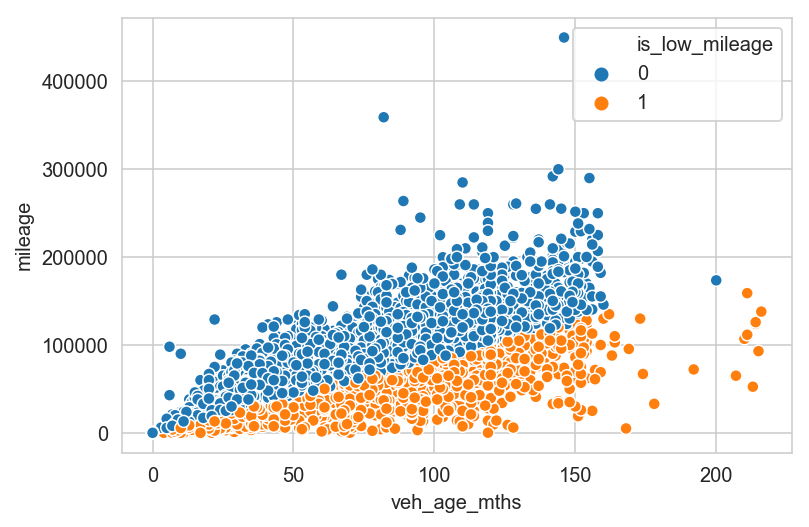

In [646]:
sns.scatterplot(x='veh_age_mths',y='mileage',data=cars,hue='is_low_mileage')

In [647]:
from sklearn.linear_model import LinearRegression

In [665]:
m=cars['mileage'][cars['mileage'].notna()]
age_lm=cars['veh_age_mths'][cars['mileage'].notna()]*cars['is_low_mileage'][cars['mileage'].notna()]
X=pd.concat([cars[['veh_age_mths','is_low_mileage']][cars['mileage'].notna()],age_lm],axis=1).values

In [668]:
lr_impute=LinearRegression().fit(X,m)

In [679]:
X_miss=cars[['veh_age_mths','is_low_mileage']][cars['mileage'].isna()]
X_miss['interaction']=cars['veh_age_mths'][cars['mileage'].isna()]*cars['is_low_mileage'][cars['mileage'].isna()]

Int64Index([    0,     1,     2,     3,     5,     6,     7,     8,     9,
               10,
            ...
            24397, 24398, 24399, 24400, 24401, 24402, 24403, 24404, 24405,
            24406],
           dtype='int64', length=9630)

In [687]:
mileage_miss=pd.Series(lr_impute.predict(X_miss),index=cars['mileage'][cars['mileage'].isna()].index)

In [688]:
cars['mileage'][cars['mileage'].isna()]=mileage_miss

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


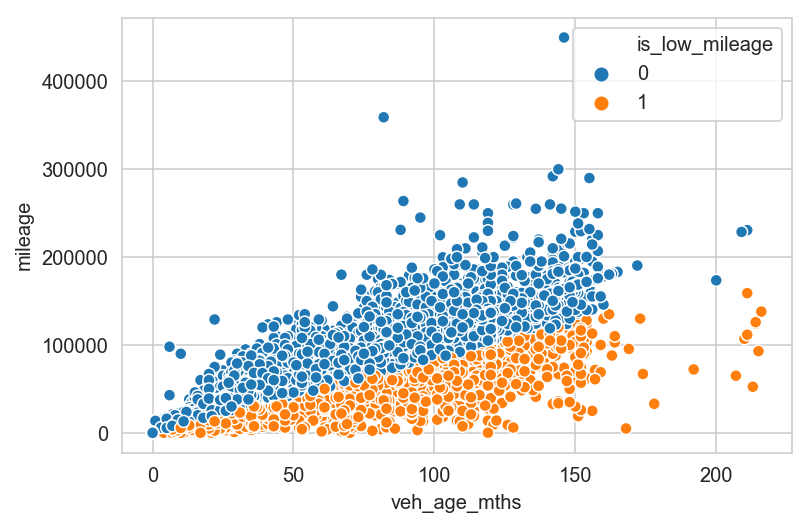

In [690]:
sns.scatterplot(x='veh_age_mths',y='mileage',data=cars,hue='is_low_mileage')